In [25]:
import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, accuracy_score, classification_report
from xgboost import XGBClassifier

In [11]:
DATA_DIR = Path("tree_data_training")
TREE_DATA = Path("final_data/trees/")

FEATURE_COLS = ['has_tree', 'avg_height', 'avg_year', 'temperature_2m', 'relative_humidity_2m', 'dew_point_2m',
       'apparent_temperature', 'precipitation', 'rain', 'snowfall',
       'snow_depth', 'weather_code', 'pressure_msl', 'surface_pressure',
       'wind_speed_10m', 'wind_direction_10m', 'wind_gusts_10m',
       'average_soil_moisture', 'average_soil_temperature', 'num_trees']

FINAL_COLS = ['avg_height', 'avg_year', 'apparent_temperature', 'rain', 'wind_speed_10m', 'wind_gusts_10m', 'num_trees', 'Fraxinus', 'Salix', 'Alnus', 'Quercus', 'Tilia', 'Acer', 'Populus', 'Betula', 'Prunus', 'Platanus', 'Malus', 'Robinia', 'Crataegus',
       'Ulmus', 'Carpinus', 'Overig', 'Onbekend']

TREE_NAMES = ['Fraxinus', 'Salix', 'Alnus', 'Quercus', 'Tilia', 'Acer', 'Populus', 'Betula', 'Prunus', 'Platanus', 'Malus', 'Robinia', 'Crataegus',
       'Ulmus', 'Carpinus', 'Overig', 'Onbekend']

TEST_PERCENTAGE = 0.2 # percentage of total
VALIDATION_PERCENTAGE = 0.25 # percentage of (1-TEST_PERCENTAGE)*total
ID_KEY = "Incident_ID"
LABEL_KEY = "Label"

SOIL_MOISTURE_COLUMNS = [
    'soil_moisture_0_to_7cm',
    'soil_moisture_7_to_28cm', 
    'soil_moisture_28_to_100cm', 
    'soil_moisture_100_to_255cm'
]

SOIL_TEMPERATURE_COLUMNS = [
    'soil_temperature_0_to_7cm',
    'soil_temperature_7_to_28cm',
    'soil_temperature_28_to_100cm',
    'soil_temperature_100_to_255cm',
]


## Data prep

In [12]:
# Load in training and testing sets
positive_path = TREE_DATA / "trees_new_grid_pos_samples.csv"
negative_path_t = TREE_DATA / "trees_new_grid_neg_samples_true.csv"
negative_path_f = TREE_DATA / "trees_new_grid_neg_samples_false.csv" 
negative_path_r = TREE_DATA / "trees_new_grid_neg_samples_random.csv" 

positive_samples_df = pd.read_csv(positive_path, sep=",", encoding="utf-8")
negative_samples_df_t = pd.read_csv(negative_path_t, sep=",", encoding="utf-8")
negative_samples_df_f = pd.read_csv(negative_path_f, sep=",", encoding="utf-8")
negative_samples_df_r = pd.read_csv(negative_path_r, sep=",", encoding="utf-8")


In [13]:
negative_samples_df = pd.concat([negative_samples_df_t, negative_samples_df_f, negative_samples_df_r], axis=0)

In [14]:
negative_samples_df.has_tree.value_counts()

has_tree
False    2387
True     2107
Name: count, dtype: int64

In [15]:
# Make sure both df's have identifiable id
# Not really necessary but makes things easier
positive_samples_df[ID_KEY] = ["P"+str(id_) for id_ in positive_samples_df['Incident_ID']]
negative_samples_df[ID_KEY] = ["N"+str(id_) for id_ in range(len(negative_samples_df))]

In [16]:
# Assign labels
positive_samples_df[LABEL_KEY] = 1
negative_samples_df[LABEL_KEY] = 0

In [17]:
positive_samples_df = positive_samples_df.fillna(0)
negative_samples_df = negative_samples_df.fillna(0)

In [18]:
# Merge df's
pos_columns = positive_samples_df.columns
neg_columns = negative_samples_df.columns
common_cols = pos_columns.intersection(neg_columns)

positive_sub_df = positive_samples_df[common_cols]
negative_sub_df = negative_samples_df[common_cols]

tree_training_df = pd.concat([positive_sub_df, negative_sub_df], axis=0)

In [19]:
def average_across_cols(
    df,
    cols,
    new_col
):
    df[new_col] = df[cols].mean(axis=1)
    return df

In [20]:
tree_training_df = average_across_cols(tree_training_df, SOIL_MOISTURE_COLUMNS, "average_soil_moisture")
tree_training_df = average_across_cols(tree_training_df, SOIL_TEMPERATURE_COLUMNS, "average_soil_temperature")

In [21]:
[tree_training_df.drop(col, axis=1, inplace=True) for col in SOIL_MOISTURE_COLUMNS]
[tree_training_df.drop(col, axis=1, inplace=True) for col in SOIL_TEMPERATURE_COLUMNS]

[None, None, None, None]

In [22]:
# create num trees col
tree_names = ['Fraxinus', 'Salix', 'Alnus', 'Quercus', 'Tilia', 'Acer', 'Populus',
       'Betula', 'Prunus', 'Platanus', 'Malus', 'Robinia', 'Crataegus',
       'Ulmus', 'Carpinus', 'Overig', 'Onbekend']
tree_training_df['num_trees'] = tree_training_df[tree_names].sum(axis=1)

In [23]:
def make_train_test(
    df,
    seed = 42,
    feature_cols = FEATURE_COLS
):
    train_ids, test_ids, train_labels, test_labels = train_test_split(df[ID_KEY], df[LABEL_KEY], test_size=TEST_PERCENTAGE, stratify=df[LABEL_KEY], random_state=seed)
    
    feature_cols = [col for col in feature_cols if col not in SOIL_MOISTURE_COLUMNS and col not in SOIL_TEMPERATURE_COLUMNS]
    print(f"Using feature cols {feature_cols}")
    
    train_set = df[df[ID_KEY].isin(train_ids)]
    test_set = df[df[ID_KEY].isin(test_ids)]

    x_train = train_set[feature_cols]
    y_train = train_set[LABEL_KEY]
    x_test = test_set[feature_cols]
    y_test = test_set[LABEL_KEY]

    return x_train, y_train, x_test, y_test

## Random forest

In [26]:
clf  = RandomForestClassifier(random_state=42, n_jobs=-1)

x_train, y_train, x_test, y_test = make_train_test(tree_training_df, feature_cols=FEATURE_COLS, seed = 42)

clf.fit(x_train, y_train)

pred = clf.predict(x_test)

print(classification_report(y_test, pred))

Using feature cols ['has_tree', 'avg_height', 'avg_year', 'temperature_2m', 'relative_humidity_2m', 'dew_point_2m', 'apparent_temperature', 'precipitation', 'rain', 'snowfall', 'snow_depth', 'weather_code', 'pressure_msl', 'surface_pressure', 'wind_speed_10m', 'wind_direction_10m', 'wind_gusts_10m', 'average_soil_moisture', 'average_soil_temperature', 'num_trees']
              precision    recall  f1-score   support

           0       0.85      0.85      0.85       899
           1       0.65      0.65      0.65       393

    accuracy                           0.79      1292
   macro avg       0.75      0.75      0.75      1292
weighted avg       0.79      0.79      0.79      1292



## XGBoost

In [27]:
# clf = XGBClassifier(verbosity=2, max_depth=15, subsample=0.9)
import xgboost

cols = ['has_tree', 'avg_height', 'avg_year', 'temperature_2m', 'relative_humidity_2m', 'dew_point_2m',
       'apparent_temperature', 'precipitation', 'rain', 'snowfall',
       'snow_depth', 'weather_code', 'pressure_msl', 'surface_pressure',
       'wind_speed_10m', 'wind_direction_10m', 'wind_gusts_10m',
       'average_soil_moisture', 'average_soil_temperature', 'num_trees']

best_cols = ['avg_height', 'avg_year', 'apparent_temperature', 'rain', 'wind_speed_10m', 'wind_gusts_10m', 'num_trees', 'Fraxinus', 'Salix', 'Alnus', 'Quercus', 'Tilia', 'Acer', 'Populus', 'Betula', 'Prunus', 'Platanus', 'Malus', 'Robinia', 'Crataegus',
       'Ulmus', 'Carpinus', 'Overig', 'Onbekend']

tree_names = ['Fraxinus', 'Salix', 'Alnus', 'Quercus', 'Tilia', 'Acer', 'Populus', 'Betula', 'Prunus', 'Platanus', 'Malus', 'Robinia', 'Crataegus',
       'Ulmus', 'Carpinus', 'Overig', 'Onbekend']

# test_cols += tree_names

x_train, y_train, x_test, y_test = make_train_test(tree_training_df, feature_cols=best_cols,  seed=42)

d_train = xgboost.DMatrix(x_train, label=y_train)
d_test = xgboost.DMatrix(x_test, label=y_test)

params = {
    "eta": 0.01,
    "objective": "binary:logistic",
    "subsample": 0.5,
    "base_score": np.mean(y_train),
    "eval_metric": "logloss",
}
model = xgboost.train(
    params,
    d_train,
    5000,
    evals=[(d_test, "test")],
    verbose_eval=100,
    early_stopping_rounds=20,
)

Using feature cols ['avg_height', 'avg_year', 'apparent_temperature', 'rain', 'wind_speed_10m', 'wind_gusts_10m', 'num_trees', 'Fraxinus', 'Salix', 'Alnus', 'Quercus', 'Tilia', 'Acer', 'Populus', 'Betula', 'Prunus', 'Platanus', 'Malus', 'Robinia', 'Crataegus', 'Ulmus', 'Carpinus', 'Overig', 'Onbekend']
[0]	test-logloss:0.61122
[100]	test-logloss:0.45619
[200]	test-logloss:0.41332
[300]	test-logloss:0.39489
[400]	test-logloss:0.38578
[500]	test-logloss:0.37984
[600]	test-logloss:0.37551
[700]	test-logloss:0.37209
[800]	test-logloss:0.36977
[900]	test-logloss:0.36729
[1000]	test-logloss:0.36514
[1100]	test-logloss:0.36336
[1200]	test-logloss:0.36154
[1219]	test-logloss:0.36183


In [27]:
preds = model.predict(xgboost.DMatrix(x_test), )
preds_t = [1 if pred >= 0.5 else 0 for pred in preds]
from sklearn.metrics import classification_report
print(classification_report(y_test, preds_t))

              precision    recall  f1-score   support

           0       0.89      0.89      0.89       899
           1       0.75      0.74      0.74       393

    accuracy                           0.84      1292
   macro avg       0.82      0.82      0.82      1292
weighted avg       0.84      0.84      0.84      1292



<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

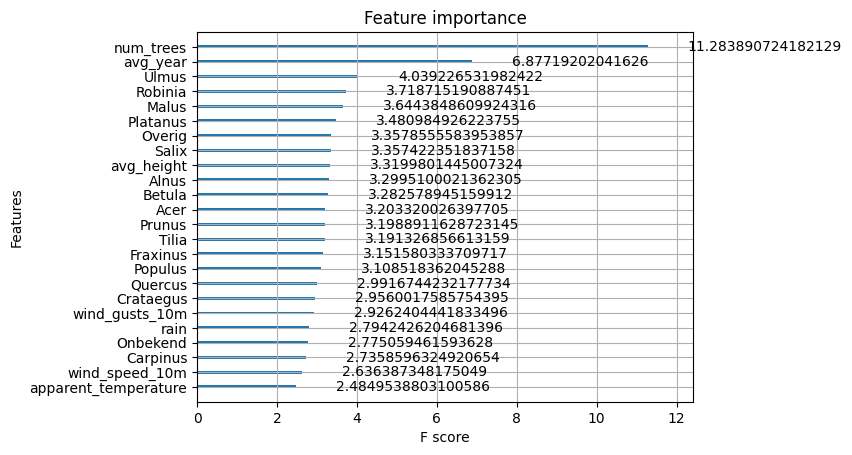

In [24]:
import xgboost
xgboost.plot_importance(model, importance_type='gain')

In [6]:
# Define the parameter grid to search
param_grid = {
    'max_depth': [5, 10, 15, 20, 25, None],
    'subsample': [0.1, 0.3, 0.5, 0.7, 0.9]
}

clf = XGBClassifier()


x_train, y_train, x_test, y_test = make_train_test(tree_training_df, feature_cols=FINAL_COLS,  seed = 42)

grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='accuracy', cv=3, verbose=3)

# Fit the model to the data
grid_search.fit(x_train, y_train)

# Get the best parameters and the best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Make predictions on the test set using the best model
y_pred = best_model.predict(x_test)

# Evaluate the best model
accuracy = accuracy_score(y_test, y_pred)
print(f'Best Parameters: {best_params}')
print(f'Best Model Accuracy: {accuracy:.2f}')

NameError: name 'XGBClassifier' is not defined

In [34]:
clf = XGBClassifier(verbosity=2, max_depth=20, subsample=0.7)

x_train, y_train, x_test, y_test = make_train_test(tree_training_df, feature_cols=FINAL_COLS)

clf.fit(x_train, y_train)

predictions = clf.predict(x_test)

print(classification_report(y_test, predictions))

Using feature cols ['avg_height', 'avg_year', 'apparent_temperature', 'rain', 'wind_speed_10m', 'wind_gusts_10m', 'num_trees', 'Fraxinus', 'Salix', 'Alnus', 'Quercus', 'Tilia', 'Acer', 'Populus', 'Betula', 'Prunus', 'Platanus', 'Malus', 'Robinia', 'Crataegus', 'Ulmus', 'Carpinus', 'Overig', 'Onbekend']
              precision    recall  f1-score   support

           0       0.87      0.90      0.88       899
           1       0.75      0.70      0.72       393

    accuracy                           0.84      1292
   macro avg       0.81      0.80      0.80      1292
weighted avg       0.83      0.84      0.84      1292



In [35]:
import pickle
#save model
with open("models/trees/xgboost_new_md20_sub70_tfr_bc.pkl", "wb") as f:
    pickle.dump(clf, f)

## LR

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
clf = LogisticRegression()

x_train, y_train, x_test, y_test = make_train_test(tree_training_df, feature_cols=cols, seed = 42)

clf.fit(x_train, y_train)
predictions = clf.predict(x_test)
print(classification_report(y_test, predictions))

Using feature cols ['has_tree', 'avg_height', 'avg_year', 'temperature_2m', 'relative_humidity_2m', 'dew_point_2m', 'apparent_temperature', 'precipitation', 'rain', 'snowfall', 'snow_depth', 'weather_code', 'pressure_msl', 'surface_pressure', 'wind_speed_10m', 'wind_direction_10m', 'wind_gusts_10m', 'average_soil_moisture', 'average_soil_temperature', 'num_trees']
              precision    recall  f1-score   support

           0       0.78      0.85      0.82       899
           1       0.57      0.46      0.51       393

    accuracy                           0.73      1292
   macro avg       0.68      0.66      0.66      1292
weighted avg       0.72      0.73      0.72      1292



/Users/Reimer/opt/anaconda3/envs/fundamentals-data-science/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## SVM

In [31]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

x_train, y_train, x_test, y_test = make_train_test(tree_training_df, feature_cols=best_cols, seed = 42)

# Create an SVM classifier
svm_clf = SVC(kernel='linear')  # You can choose different kernels like 'linear', 'rbf', 'poly', etc.

# Train the classifier
svm_clf.fit(x_train, y_train)

# Make predictions on the test set
y_pred = svm_clf.predict(x_test)

print(classification_report(y_test, y_pred))


Using feature cols ['avg_height', 'avg_year', 'apparent_temperature', 'rain', 'wind_speed_10m', 'wind_gusts_10m', 'num_trees', 'Fraxinus', 'Salix', 'Alnus', 'Quercus', 'Tilia', 'Acer', 'Populus', 'Betula', 'Prunus', 'Platanus', 'Malus', 'Robinia', 'Crataegus', 'Ulmus', 'Carpinus', 'Overig', 'Onbekend']
              precision    recall  f1-score   support

           0       0.82      0.88      0.85       899
           1       0.66      0.55      0.60       393

    accuracy                           0.78      1292
   macro avg       0.74      0.71      0.72      1292
weighted avg       0.77      0.78      0.77      1292



## Inference

In [3]:
grid_gdf = pd.read_csv("final_data/grids/grids_enriched_NEW.csv", sep=",", encoding="utf-8")

In [36]:
from TreeInference import makeTreePrediction
from pathlib import Path

predictor = makeTreePrediction(model_name="xgboost_new_md20_sub70_tfr_bc.pkl", grid_df=grid_gdf, hours_to_predict=8)
pred_dict = predictor.get_predictions()